[Cloud Functions 2nd Gen: Qwik Start](https://www.cloudskillsboost.google/focuses/49757?catalog_rank=%7B%22rank%22%3A1%2C%22num_filters%22%3A0%2C%22has_search%22%3Atrue%7D&parent=catalog&search_id=23703804)

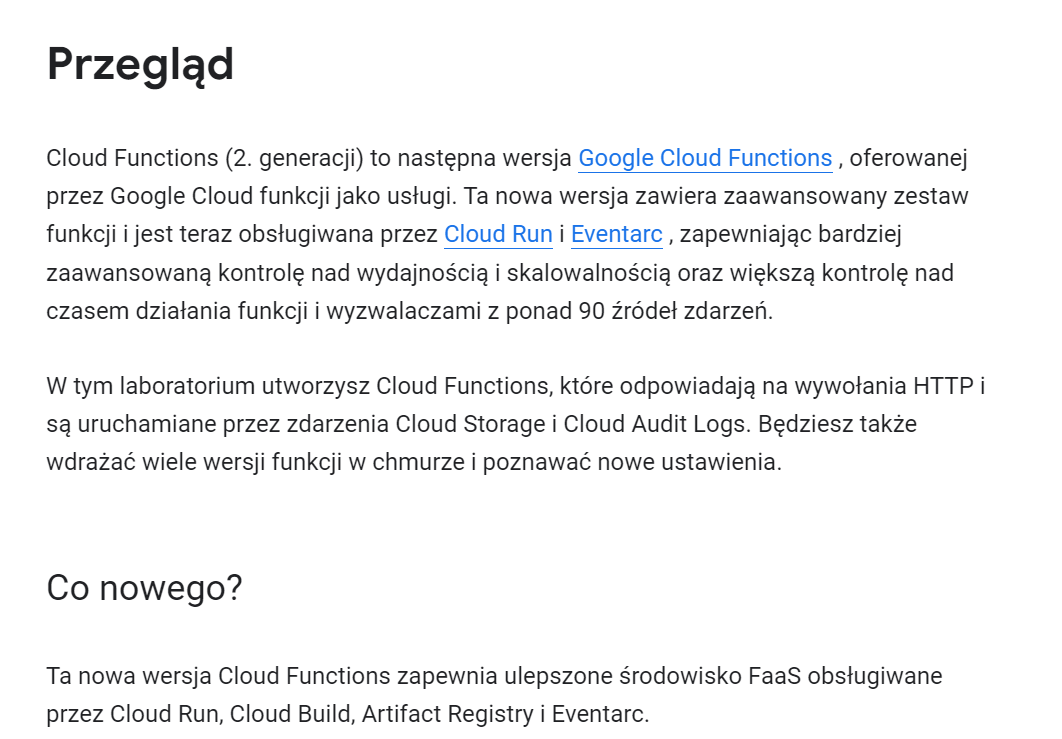

In [ ]:
# https://cloud.google.com/functions

# https://cloud.google.com/run

# https://cloud.google.com/eventarc/docs

**Eventarc** to usługa zarządzania zdarzeniami w chmurze Google Cloud Platform. Pozwala ona na przechwytywanie i przetwarzanie zdarzeń pochodzących z różnych źródeł w GCP, takich jak usługi obliczeniowe, magazyny danych czy usługi zewnętrzne.

Dzięki Eventarc można w łatwy sposób przetwarzać zdarzenia w czasie rzeczywistym, automatycznie uruchamiając odpowiednie funkcje lub usługi w chmurze. Eventarc umożliwia również konfigurację różnych kanałów dostarczania zdarzeń do aplikacji, a także umożliwia integrację z różnymi narzędziami i usługami w chmurze GCP, takimi jak Cloud Run, Cloud Functions czy Cloud Pub/Sub.

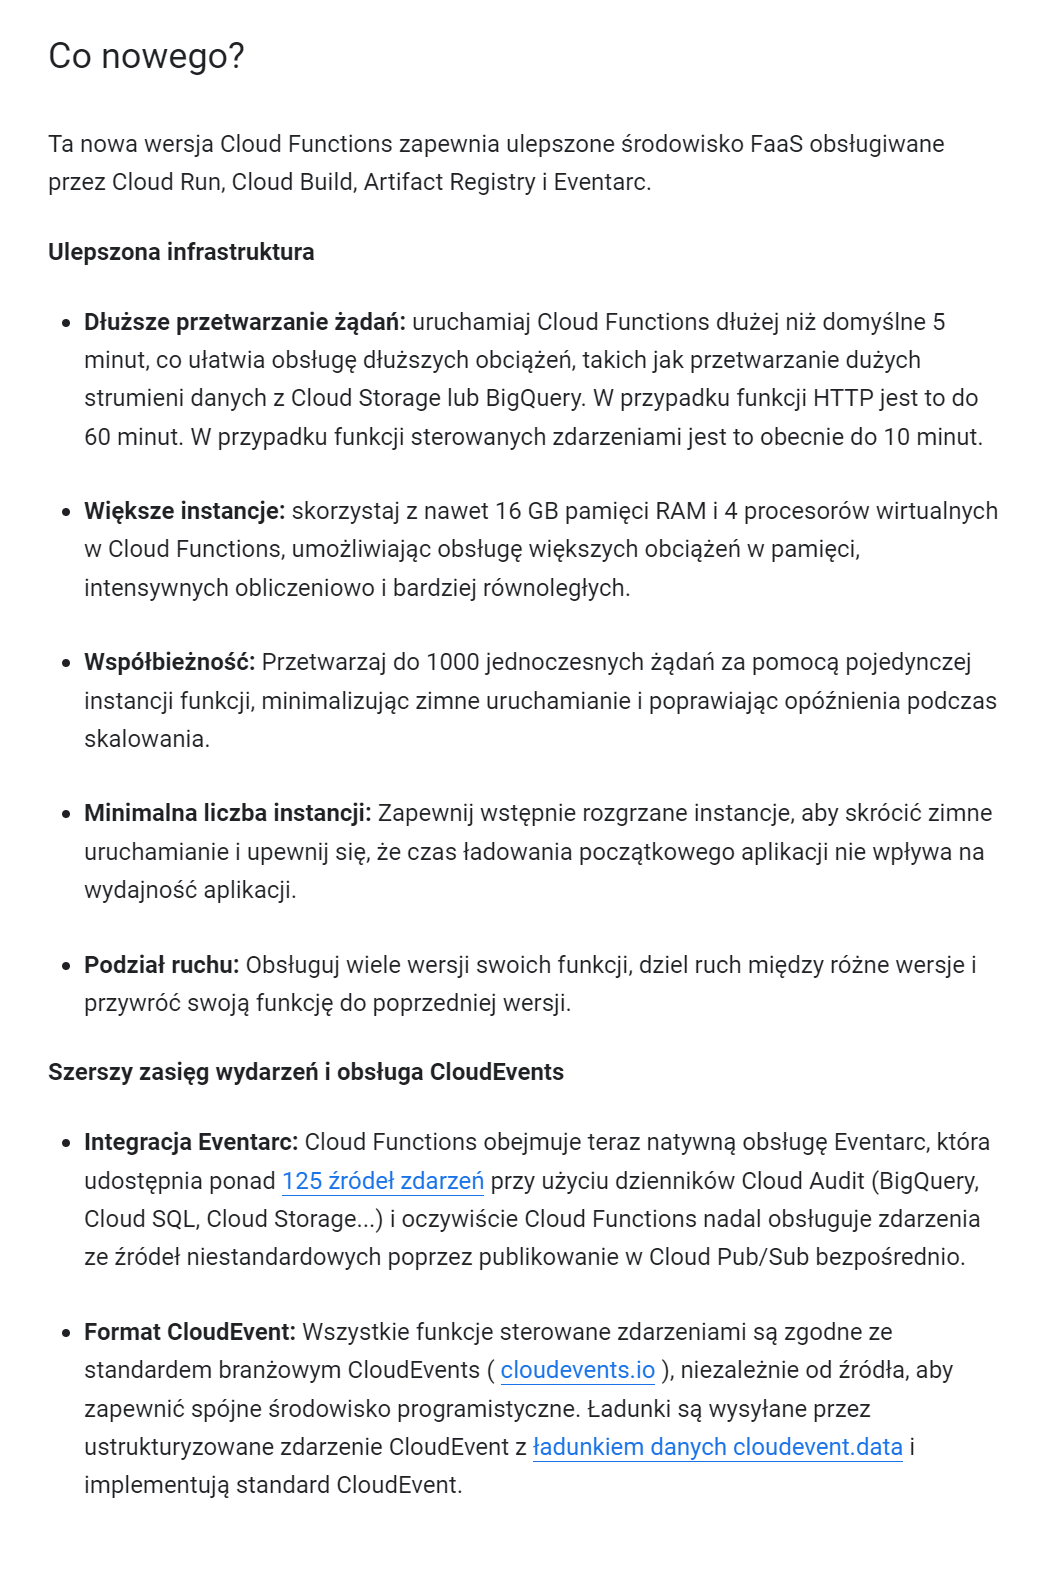

In [ ]:
# https://cloud.google.com/eventarc/docs/reference/supported-events

# https://cloudevents.io/

# https://cloud.google.com/eventarc/docs/cloudevents

**Środowisko FaaS (Function as a Service)** to model dostarczania usług obliczeniowych, który umożliwia deweloperom uruchamianie kodu w postaci funkcji bez potrzeby zarządzania serwerami ani środowiskiem uruchomieniowym. Deweloperzy mogą przesłać kod źródłowy funkcji do platformy FaaS, a platforma będzie zajmować się uruchamianiem, skalowaniem oraz zarządzaniem infrastrukturą, w której kod działa.

Dzięki FaaS deweloperzy mogą koncentrować się na tworzeniu kodu, a nie na zarządzaniu serwerami, wirtualnymi maszynami czy kontenerami. W ten sposób mogą szybciej i łatwiej wdrażać aplikacje oraz skupiać się na innowacjach, a nie na administracji systemami. W przypadku funkcji uruchamianych na FaaS, rozliczanie następuje na poziomie jednostek czasu (np. 100ms), a nie na poziomie wykorzystanych zasobów, co pozwala na bardziej elastyczne i precyzyjne skalowanie.

Przykłady platform FaaS to m.in. AWS Lambda, Google Cloud Functions czy Azure Functions.

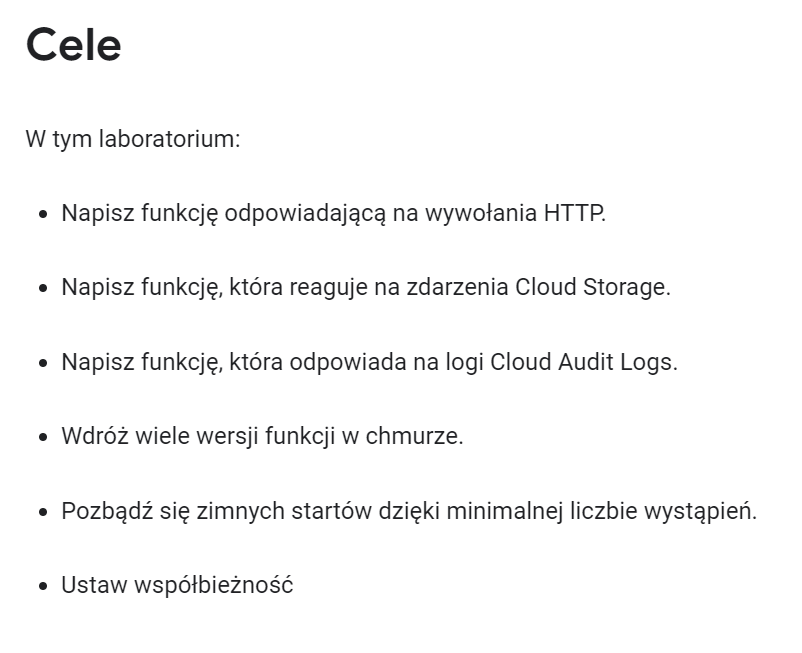

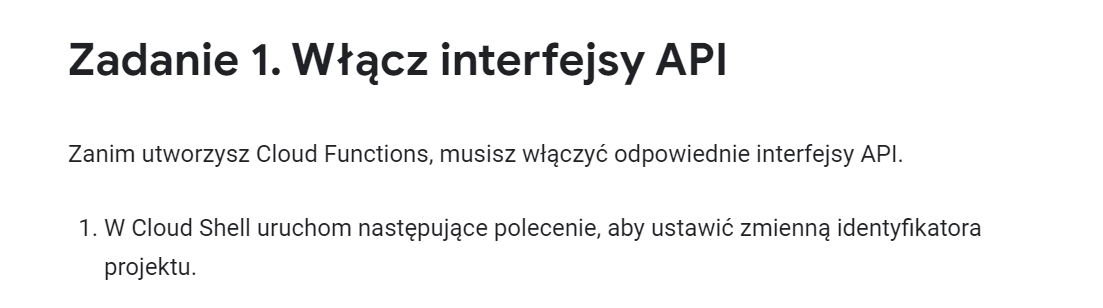

In [ ]:
export PROJECT_ID=$(gcloud config get-value project)

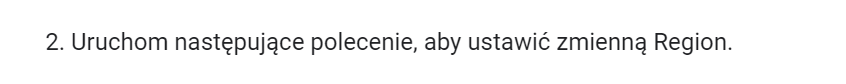

In [ ]:
export REGION=""
gcloud config set compute/region $REGION

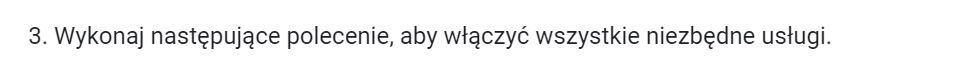

In [ ]:
gcloud services enable \
  artifactregistry.googleapis.com \
  cloudfunctions.googleapis.com \
  cloudbuild.googleapis.com \
  eventarc.googleapis.com \
  run.googleapis.com \
  logging.googleapis.com \
  pubsub.googleapis.com

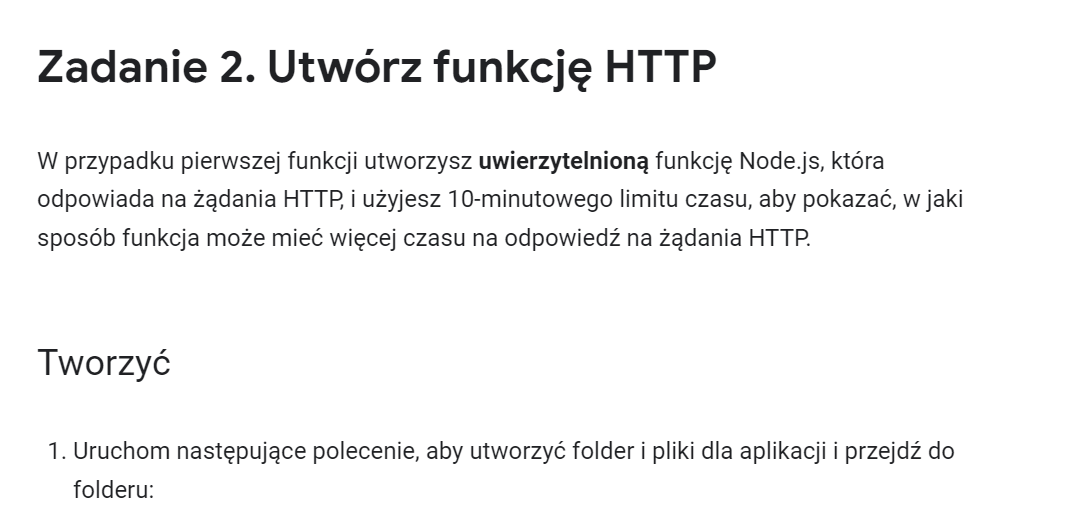

In [ ]:
mkdir ~/hello-http && cd $_
touch index.js && touch package.json

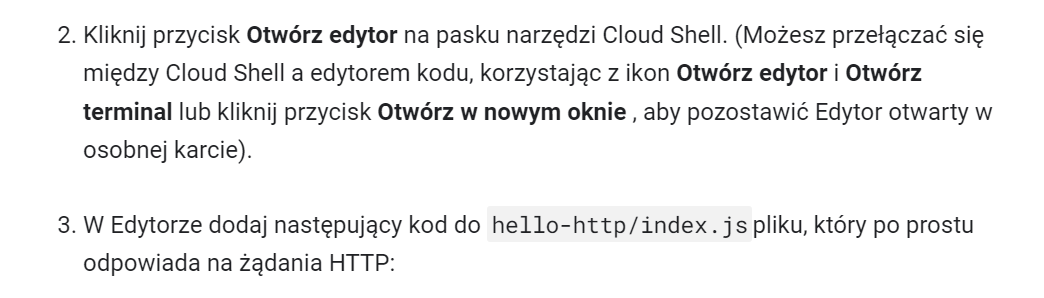

In [ ]:
const functions = require('@google-cloud/functions-framework');
functions.http('helloWorld', (req, res) => {
  res.status(200).send('HTTP with Node.js in GCF 2nd gen!');
});

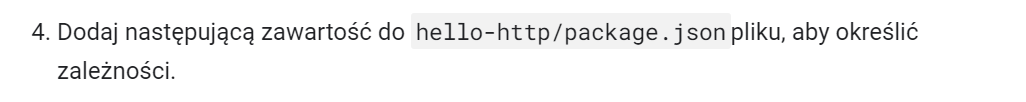

In [ ]:
{
  "name": "nodejs-functions-gen2-codelab",
  "version": "0.0.1",
  "main": "index.js",
  "dependencies": {
    "@google-cloud/functions-framework": "^2.0.0"
  }
}

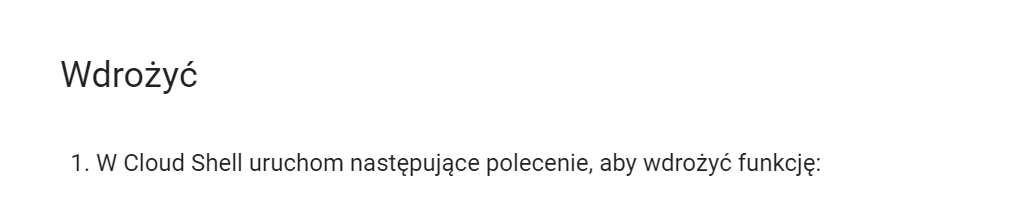

In [ ]:
gcloud functions deploy nodejs-http-function \
  --gen2 \
  --runtime nodejs16 \
  --entry-point helloWorld \
  --source . \
  --region $REGION \
  --trigger-http \
  --timeout 600s \
  --max-instances 1

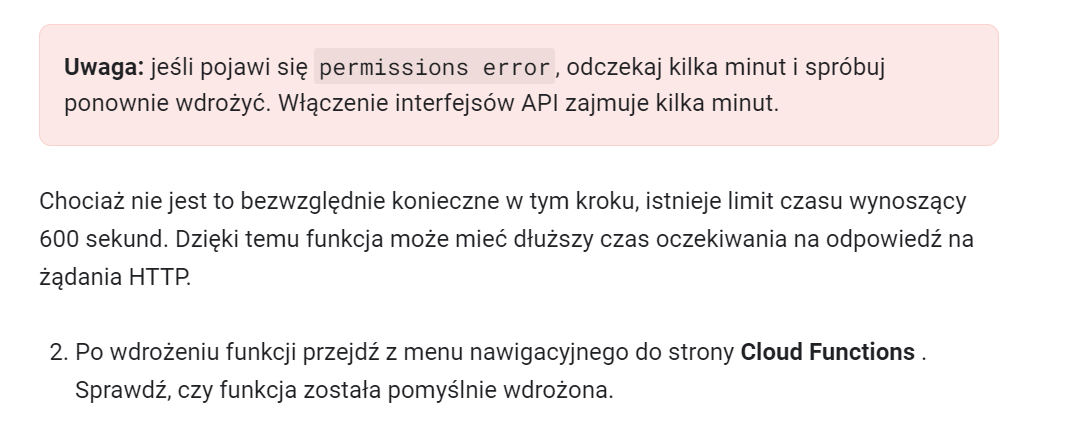

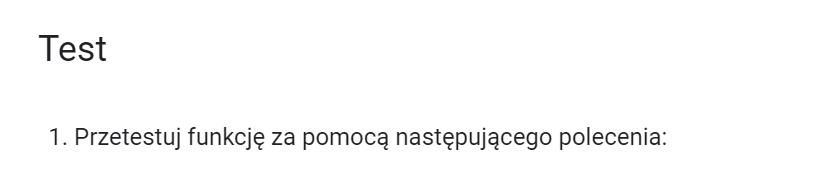

In [ ]:
gcloud functions call nodejs-http-function \
  --gen2 --region $REGION

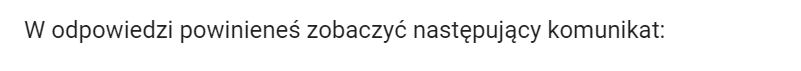

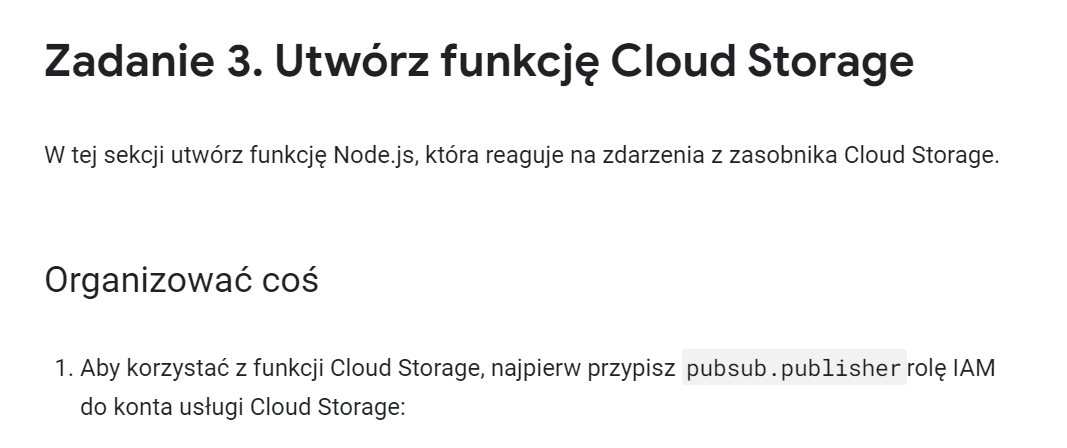

In [ ]:
PROJECT_NUMBER=$(gcloud projects list --filter="project_id:$PROJECT_ID" --format='value(project_number)')
SERVICE_ACCOUNT=$(gsutil kms serviceaccount -p $PROJECT_NUMBER)
gcloud projects add-iam-policy-binding $PROJECT_ID \
  --member serviceAccount:$SERVICE_ACCOUNT \
  --role roles/pubsub.publisher

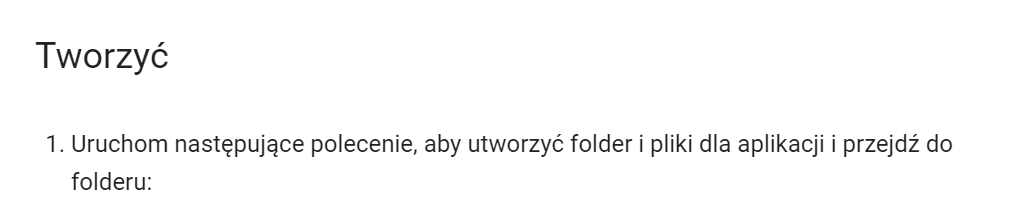

In [ ]:
mkdir ~/hello-storage && cd $_
touch index.js && touch package.json

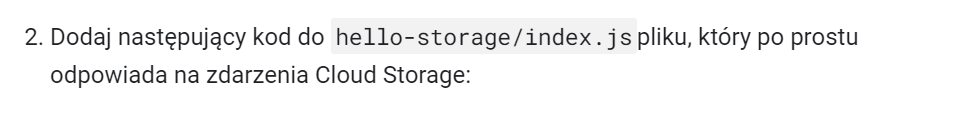

In [ ]:
const functions = require('@google-cloud/functions-framework');
functions.cloudEvent('helloStorage', (cloudevent) => {
  console.log('Cloud Storage event with Node.js in GCF 2nd gen!');
  console.log(cloudevent);
});

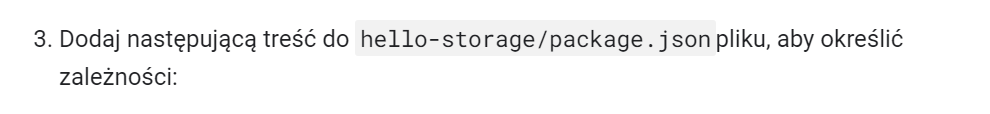

In [ ]:
{
  "name": "nodejs-functions-gen2-codelab",
  "version": "0.0.1",
  "main": "index.js",
  "dependencies": {
    "@google-cloud/functions-framework": "^2.0.0"
  }
}

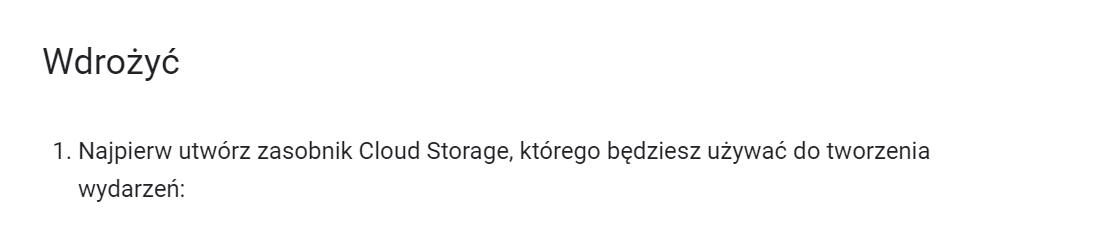

In [ ]:
BUCKET="gs://gcf-gen2-storage-$PROJECT_ID"
gsutil mb -l $REGION $BUCKET

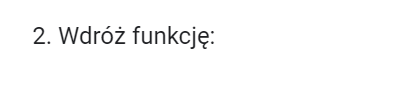

In [ ]:
gcloud functions deploy nodejs-storage-function \
  --gen2 \
  --runtime nodejs16 \
  --entry-point helloStorage \
  --source . \
  --region $REGION \
  --trigger-bucket $BUCKET \
  --trigger-location $REGION \
  --max-instances 1

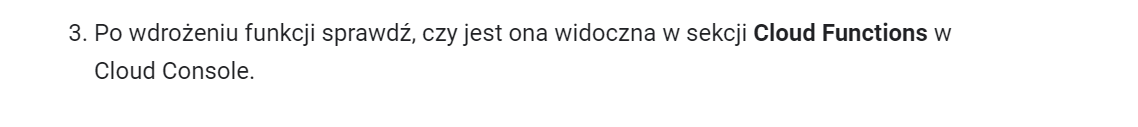

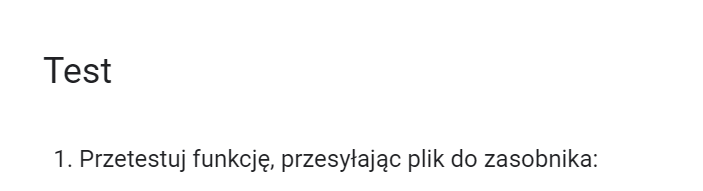

In [ ]:
echo "Hello World" > random.txt
gsutil cp random.txt $BUCKET/random.txt

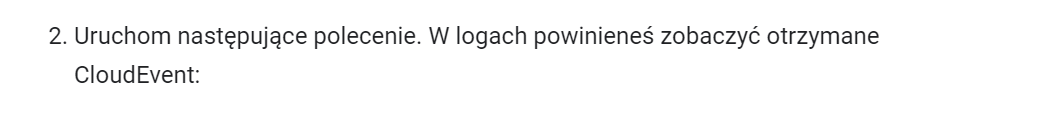

In [ ]:
gcloud functions logs read nodejs-storage-function \
  --region $REGION --gen2 --limit=100 --format "value(log)"

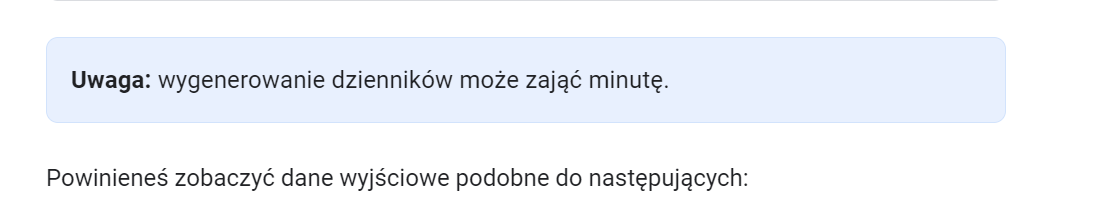

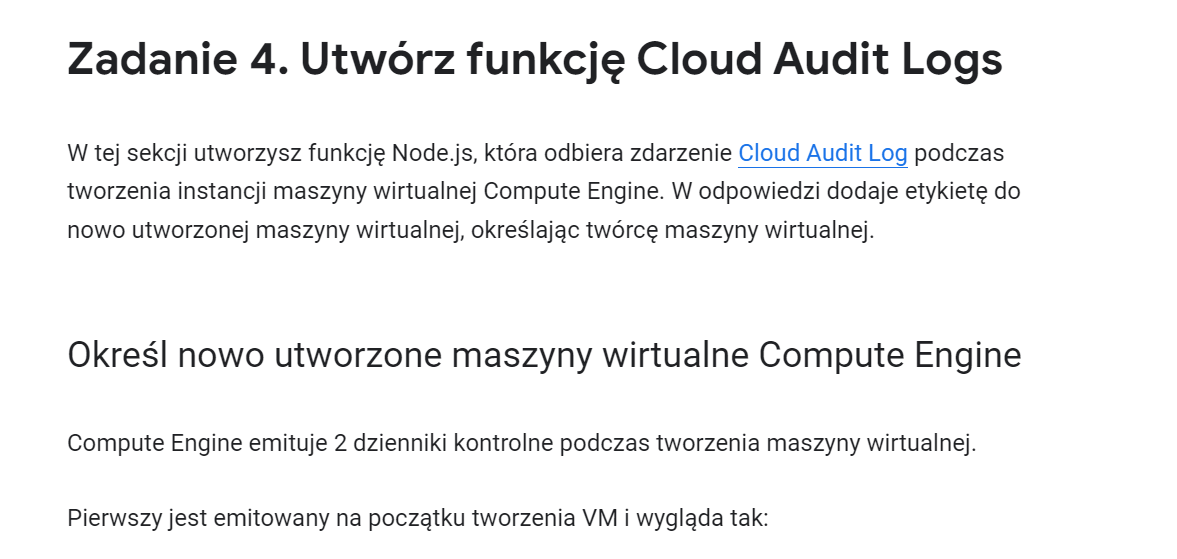

In [ ]:
# https://cloud.google.com/logging/docs/audit

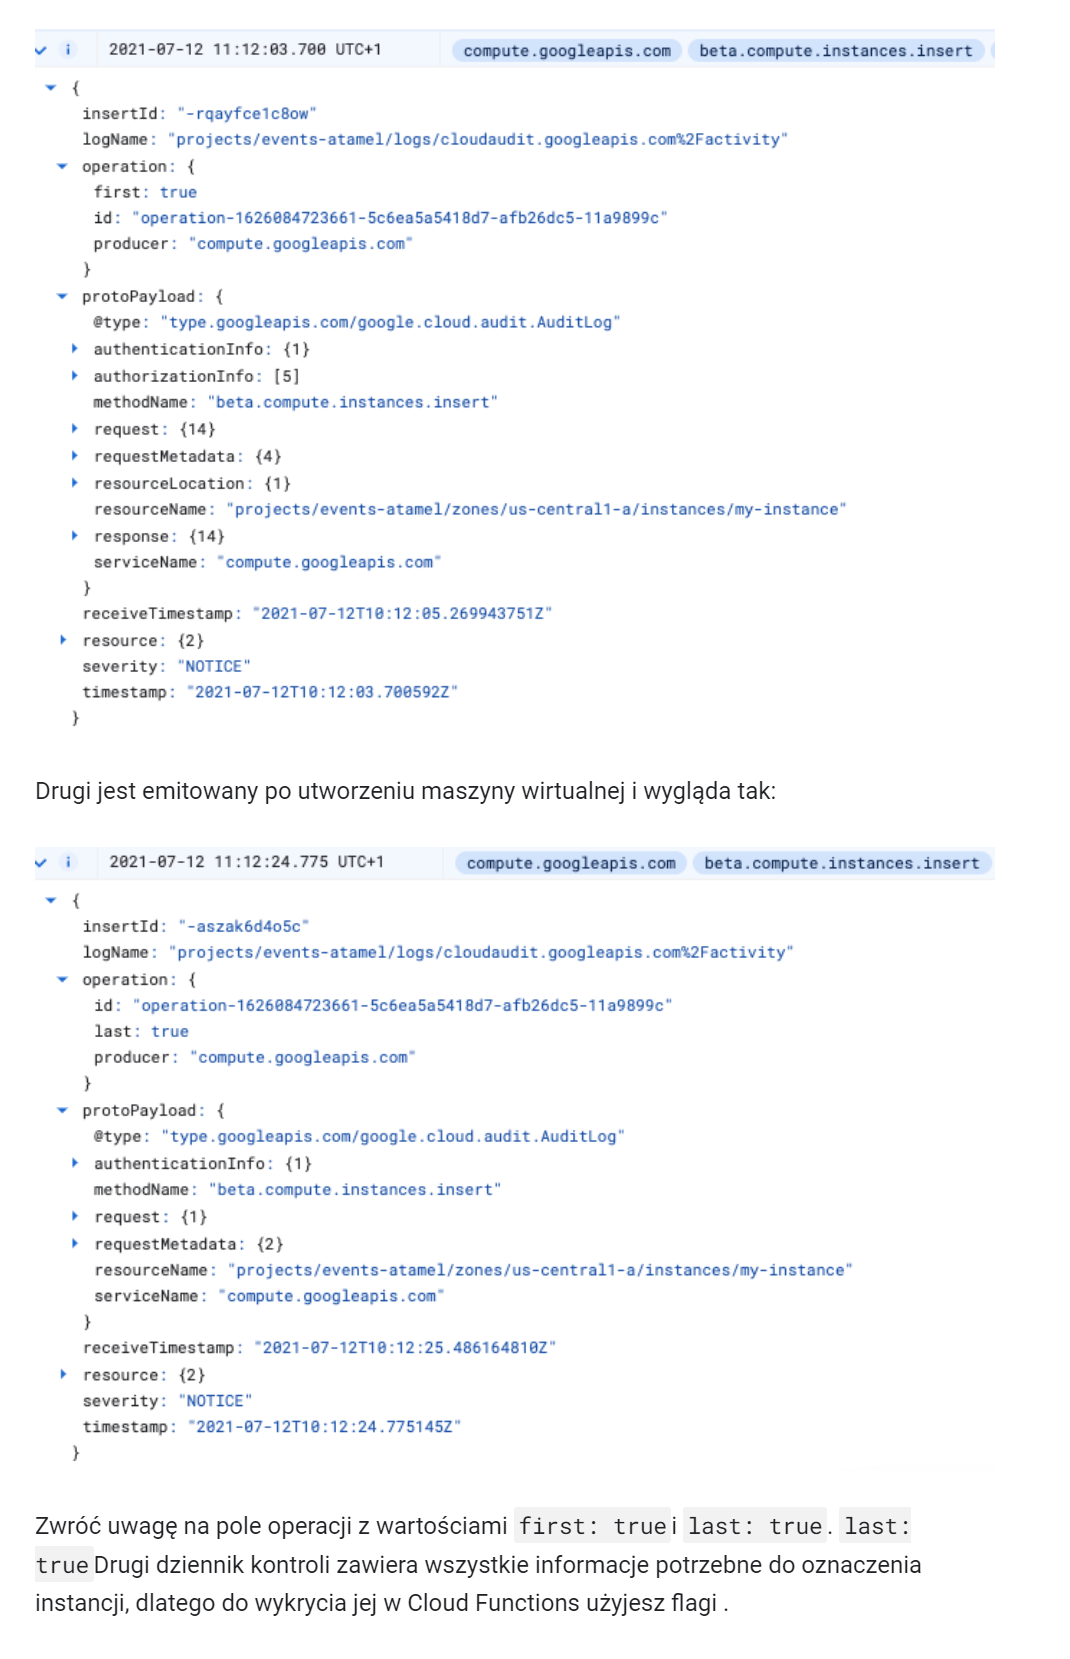

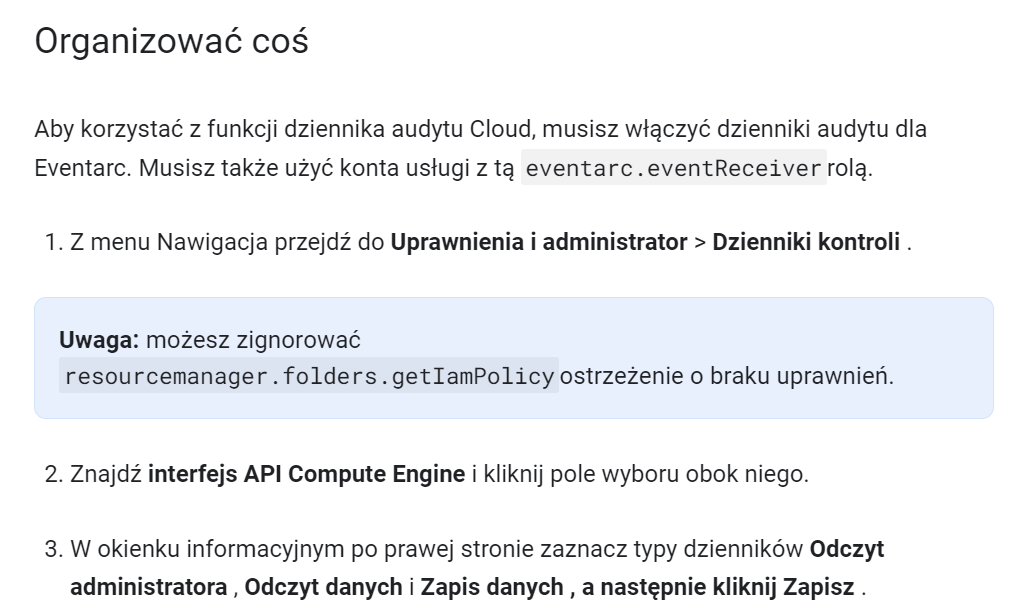

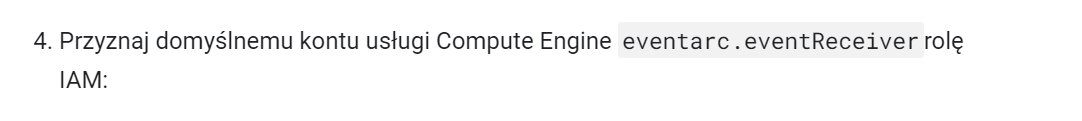

In [ ]:
gcloud projects add-iam-policy-binding $PROJECT_ID \
  --member serviceAccount:$PROJECT_NUMBER-compute@developer.gserviceaccount.com \
  --role roles/eventarc.eventReceiver

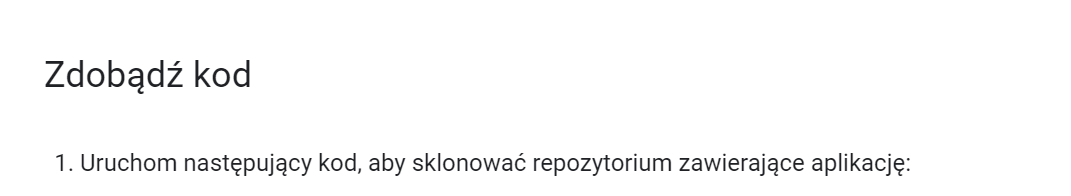

In [ ]:
cd ~
git clone https://github.com/GoogleCloudPlatform/eventarc-samples.git

In [ ]:
# https://github.com/GoogleCloudPlatform/eventarc-samples

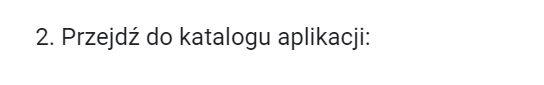

In [ ]:
cd ~/eventarc-samples/gce-vm-labeler/gcf/nodejs

In [ ]:
# https://github.com/GoogleCloudPlatform/eventarc-samples/tree/main/gce-vm-labeler/gcf/nodejs

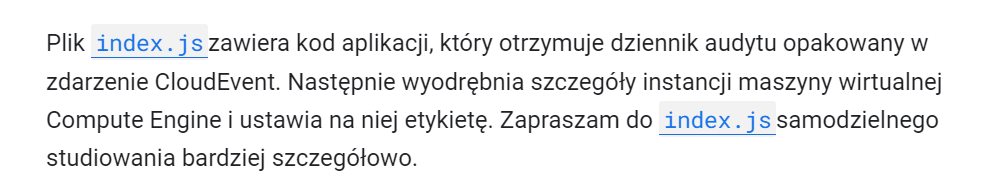

In [ ]:
%%javascript

const { google } = require("googleapis");
var compute = google.compute("v1");

exports.labelVmCreation = async (cloudevent) => {
  var data = cloudevent;

  // in case an event has >1 audit log
  // make sure we respond to the last event
  if (!data.operation.last) {
    console.log("Operation is not last, skipping event");
    return;
  }

  // projects/dogfood-gcf-saraford/zones/us-central1-a/instances/instance-1
  var resourceName = data.protoPayload.resourceName;
  var resourceParts = resourceName.split("/");
  var project = resourceParts[1];
  var zone = resourceParts[3];
  var instanceName = resourceParts[5];
  var username = data.protoPayload.authenticationInfo.principalEmail.split("@")[0];

  console.log(`Setting label username: ${username} to instance ${instanceName} for zone ${zone}`);

  var authClient = await google.auth.getClient({
    scopes: ["https://www.googleapis.com/auth/cloud-platform"]
  });

  // per docs: When updating or adding labels in the API,
  // you need to provide the latest labels fingerprint with your request,
  // to prevent any conflicts with other requests.
  var labelFingerprint = await getInstanceLabelFingerprint(authClient, project, zone, instanceName);

  var responseStatus = await setVmLabel(
    authClient,
    labelFingerprint,
    username,
    project,
    zone,
    instanceName
  );

  // log results of setting VM label
  console.log(JSON.stringify(responseStatus, null, 2));
};

async function getInstanceLabelFingerprint(authClient, project, zone, instanceName) {
  var request = {
    project: project,
    zone: zone,
    instance: instanceName,
    auth: authClient
  };

  var response = await compute.instances.get(request);
  var labelFingerprint = response.data.labelFingerprint;
  return labelFingerprint;
}

async function setVmLabel(authClient, labelFingerprint, username, project, zone, instanceName) {
  var request = {
    project: project,
    zone: zone,
    instance: instanceName,

    resource: {
      labels: { "creator": username },
      labelFingerprint: labelFingerprint
    },

    auth: authClient
  };

  var response = await compute.instances.setLabels(request);
  return response.statusText;
}

Kod przekształcony z NodeJS do Python:

In [5]:
if not True: # data['operation']['last'] = True
    print("Operation is not last, skipping event")

In [ ]:
"""Na początku importujemy potrzebne moduły: discovery z googleapiclient oraz service_account z google.oauth2.
Moduł discovery służy do tworzenia klientów API dla usług GCP, a service_account
jest wykorzystywany do uwierzytelniania za pomocą konta usługi."""
from googleapiclient import discovery
from google.oauth2 import service_account


"""Funkcja label_vm_creation() jest główną funkcją. Przyjmuje argument cloudevent, który zawiera dane zdarzenia chmury.
Sprawdza, czy zdarzenie jest ostatnie, a następnie pobiera niezbędne informacje, takie jak nazwa projektu, strefa
i nazwa instancji maszyny wirtualnej, oraz nazwa użytkownika. Następnie autoryzuje klienta za pomocą klucza usługi,
uzyskuje ślad odcisku palca etykiety i ustawia etykietę dla maszyny wirtualnej."""
def label_vm_creation(cloudevent):
    data = cloudevent

    # w przypadku gdy zdarzenie ma więcej niż 1 log audytowy
    # upewniamy się, że reagujemy tylko na ostatnie zdarzenie
    if not data['operation']['last']:
        print("Operation is not last, skipping event")
        return

    # projects/dogfood-gcf-saraford/zones/us-central1-a/instances/instance-1
    resource_name = data['protoPayload']['resourceName']
    resource_parts = resource_name.split("/")
    project = resource_parts[1]
    zone = resource_parts[3]
    instance_name = resource_parts[5]
    username = data['protoPayload']['authenticationInfo']['principalEmail'].split("@")[0]

    print(f"Setting label username: {username} to instance {instance_name} for zone {zone}")

    # autoryzacja z wykorzystaniem usługi Google Cloud
    credentials = service_account.Credentials.from_service_account_file(
        'service_account_key.json',
        scopes=["https://www.googleapis.com/auth/cloud-platform"]
    )
    auth_client = credentials.with_subject('your-service-account-email@your-project-id.iam.gserviceaccount.com')

    # uzyskanie śladu odcisku palca etykiety
    label_fingerprint = get_instance_label_fingerprint(auth_client, project, zone, instance_name)

    # ustawienie etykiety dla maszyny wirtualnej
    response_status = set_vm_label(auth_client, label_fingerprint, username, project, zone, instance_name)

    # logowanie wyników ustawienia etykiety VM
    print(response_status)


"""Funkcje pomocnicze get_instance_label_fingerprint() i set_vm_label() służą odpowiednio do pobierania śladu
odcisku palca etykiety i ustawiania etykiety dla maszyny wirtualnej. Wykorzystują one klienta Compute Engine API
do komunikacji z GCP."""
def get_instance_label_fingerprint(auth_client, project, zone, instance_name):
    compute = discovery.build('compute', 'v1', credentials=auth_client)
    request = compute.instances().get(project=project, zone=zone, instance=instance_name)
    response = request.execute()
    return response.get('labelFingerprint', None)


def set_vm_label(auth_client, label_fingerprint, username, project, zone, instance_name):
    compute = discovery.build('compute', 'v1', credentials=auth_client)
    request_body = {
        "labels": {"creator": username},
        "labelFingerprint": label_fingerprint
    }
    request = compute.instances().setLabels(project=project, zone=zone, instance=instance_name, body=request_body)
    response = request.execute()
    return response.get('statusText', None)


# Wywołanie funkcji label_vm_creation(cloudevent) z odpowiednio sformatowanym obiektem cloudevent


Opcjonalny kod do wywołania kodu lokalnie i zbędny kiedy GCP pobierze dane z Cloud Audit Logs.

In [ ]:
# Wywołanie funkcji label_vm_creation z odpowiednio sformatowanym obiektem cloudevent
cloudevent = {
    'operation': {'last': True},  # przykładowe dane, należy dostosować do rzeczywistego cloudevent
    'protoPayload': {
        'resourceName': 'projects/my-project/zones/us-central1-a/instances/my-instance-1',
        'authenticationInfo': {'principalEmail': 'user@example.com'}
    }
}

label_vm_creation(cloudevent)